<a href="https://colab.research.google.com/github/moey920/NLP/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC_%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글 텍스트 분류 튜토리얼(케라스)

## 소개

이번에는 구글 비전을 통해 얻어낸 영수증의 OCR 결과를 가지고 카테고리를 분류 하는 딥러닝 모델을 구현해보도록 하겠습니다.

이 튜토리얼은 케라스와 영수증 데이터셋을 활용하여 딥러닝 모델로 어떻게 카테고리를 분류 하는지 봅니다. 

튜토리얼 시작에 앞서서 어떻게 진행하는지에 대해서 아래 목차를 확인하고 가도록 합시다.
1. 로이터에서 제공하는 뉴스와이어 데이터셋 확인

2. 데이터 불러오기 - 영수증 데이터셋을 어떻게 불러와 다루는지 보도록 합니다.

3. 데이터 분석

  2.1 리뷰 길이 분포 - 전체 데이터 길이가 어떠한 분포로 되어있는지 확인해보도록 합니다.
  
  2.2 데이터 라벨 분포 - 데이터 학습 라벨 분포가 어떻게 되어있는지 확인해보도록 합니다.
  
  2.3 워드클라우드 - 데이터에 가장 빈번하게 등장하는 단어들이 어떤건지 확인해보도록 합니다.
  
  2.4 기타 - 그 외에 어떠한 데이터를 알아 볼 수 있는지 봅시다.
  
4. 전처리

  3.1 형태소 분석 - 형태소 분석을 통해 한글 토크나이징을 어떻게 하는지 보도록 합니다. 
  
  3.2 불용어 처리 - 어떤 단어를 불용어라 보는지 확인하고 어떻게 데이터에서 제거하는지 보도록 합니다.
  
  3.3 인덱싱 - 모델에 학습하기 위해 단어 사전을 어떻게 구성하는지 보고 텍스트를 어떻게 인덱싱하는지 보도록 합니다.
  
5. 모델 학습 - 모델링은 케라스를 통해 어떻게 데이터를 입력하고 모델 학습을 하는지 보도록 합니다.

  4.1 데이터 입력 함수 - 모델 학습과 평가를 위해 어떻게 데이터를 구성하는지 알아보도록 합니다.
  
  4.2 모델 함수 - CNN 모델을 어떻게 만드는지 보고 이 모델로 어떻게 텍스트 분류기를 만드는지 보도록 합니다.
  
  4.3 학습 및 평가 - 케라스를 가지고 어떻게 모델 학습과 평가를 하는지 보도록 합니다.
  


In [10]:
!pip install konlpy

In [11]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
# apt가 작동하지 않는데, 일단은 그냥 다음 코드로 진행하셔도 괜찮습니다.
#!pip install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

## 1. 로이터 데이터셋 확인

보통 문장(시계열수치) 입력 다중클래스 분류 모델의 대표적인 예시는 로이터에서 제공하는 뉴스와이어 데이터셋을 이용하는 것입니다. 따라서 어떻게 데이터셋을 생성해야 할 지 파악하기 위해서 로이터 데이터셋을 불러와서 확인해보도록 하겠습니다.

이 데이터셋은 총 11,228개의 샘플로 구성되어 있습니다. 라벨은 46개 주제로 지정되어 0에서 45의 값을 가지고 있습니다. 케라스에서 제공하는 reuters의 load_data() 함수을 이용하면 데이터셋을 쉽게 얻을 수 있습니다. 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냅니다. 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성합니다. 15,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 15000이라고 지정하면 됩니다.

In [0]:
from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000)

In [13]:
print(x_train)

[list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])
 list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])
 list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89, 90,

로이터 데이터셋의 x_train을 출력해보면 하나의 문장(뉴스)의 각 단어를 정수로 인코딩하였습니다.(정수의 의미: 어느 단어의 빈도수) 그리고 모든 뉴스(11,228)에 대해 각 리스트가 형성되어 있습니다.

또한 로이터 데이터셋 홈페이지에 들어가서 압축파일을 열어보면 7개의 데이터셋과 카테고리에 대한 단어들의 인덱싱 파일이 저장되어 있습니다.

그러면 영수증에 대해서는 어떻게 처리해야할까요?

일단 영수증 데이터를 불러와서 전처리 해보도록 합시다.

## 라이브러리 불러오기

여러분들이 텍스트 분류기를 만들기 위해서는 다음과 같은 라이브러리들이 필요합니다.

- numpy: 벡터 연산 및 여러 수학 연산에서 많이 사용합니다.

- pandas: raw 테이블 데이터를 입력받고 처리하는데 사용합니다.

- matplotlib: 데이터 분석 시에 통계를 보는데 사용합니다.

- wordcloud: 단어 분포를 보는데 사용합니다.

In [0]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

## 데이터 불러오기

판다스 라이브러리를 통해 텍스트 데이터를 불러오도록 합니다.

(현재 텍스트 데이터는 구글 드라이브에 저장된 csv 파일(텍스트)을 불러오는겁니다.)

In [0]:
train_file_link = '/content/drive/My Drive/text/dataset.txt'

In [16]:
# 불러온 데이터를 보면 id, document, label로 구분이 되어있습니다.
train_data = pd.read_csv(train_file_link, header = 0, delimiter = '\t', quoting = 3)
train_data.head(10)

,id,document,label
0,1,성북도 청주시 흥덕구 사운로 303,2
1,2,6098101574 구장고 TEL : 043- 260 - 15,3
2,3,2020- 02 - 29 20 : 17 : 29 POS : 1001 -00081 M...,4
3,4,고객센터 : 1577 - 4887 www .eliveyoung . co . KI,0
4,5,교환/ 환불은 결제일로부터 15일(3월 15일) 내,0
5,6,판매가능한 정상품( 미개봉) 에 한해 결제했던,0
6,7,수단과 구매영수증 지참 후 매장 방문시 가능,0
7,8,* 단 환불/ 결제수단 변경은 구매매장에서만,0
8,9,가능.,0
9,10,* 부분교환 영수증/선물교환중에 의한 환불은,0


## 데이터 분석

불러온 텍스트 데이터를 이제 하나하나 분석을 해보며 이 데이터는 어떻게 구성이 되어있는지 알아가보도록 합시다.

### 학습 데이터 갯수

In [17]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 40000


### 텍스트 길이 분포

텍스트 분류 모델링을 하는 경우 전체 학습 데이터 길이가 어떻게 되는지 아는게 중요할 때가 있습니다. 

여기서는 Character 단위 Word 단위 2가지로 나누어 분포를 확인해보고자 합니다.

In [0]:
train_lenght = train_data['document'].astype(str).apply(len)

Text(0, 0.5, 'Number of sentense')

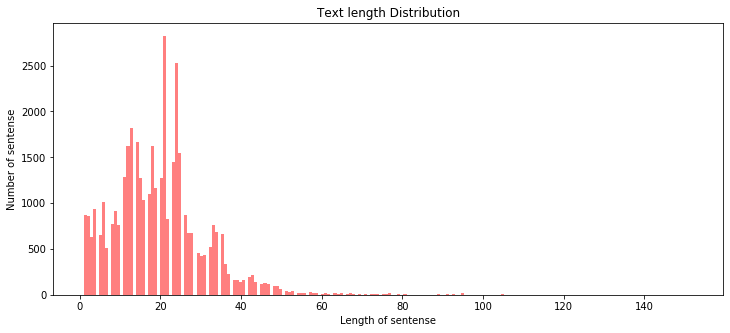

In [19]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_lenght, bins=200, alpha=0.5, color= 'r', label='word')
# plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Text length Distribution')
# 그래프 x 축 라벨
plt.xlabel('Length of sentense')
# 그래프 y 축 라벨
plt.ylabel('Number of sentense')

In [20]:
print('문장 길이 최대 값: {}'.format(np.max(train_lenght)))
print('문징 길이 최소 값: {}'.format(np.min(train_lenght)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_lenght)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_lenght)))
print('문장 길이 중간 값: {}'.format(np.median(train_lenght)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_lenght, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_lenght, 75)))

문장 길이 최대 값: 152
문징 길이 최소 값: 1
문장 길이 평균 값: 19.60
문장 길이 표준편차: 11.50
문장 길이 중간 값: 19.0
문장 길이 제 1 사분위: 12.0
문장 길이 제 3 사분위: 25.0


### 데이터 라벨 분포

이 영수증 텍스트 데이터 라벨은 15 종류로 되어 있습니다.

1. 브랜드명, 지점명
2. 주소
3. 사업자등록번호, 지점대표, 전화번호
4. 구매일시
5. 상품명
6. 상품바코드, 단가, 수량, 금액
7. 결제금액
8. 카드금액
9. 카드번호
10. 카드사명
11. 카드승인번호
12. 영수증 바코드
13. 결제방법
14. 현금영수증 승인번호  
0: 불필요 
로 분류했습니다.


각 데이터 라벨의 분포가 어떠한지 살펴봅시다.

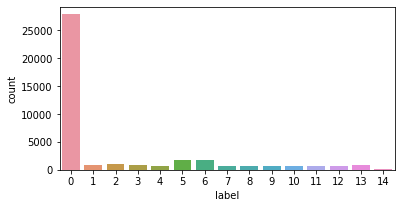

In [21]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

불필요 카테고리가 압도적으로 많은 것을 확인할 수 있습니다.

In [22]:
print("불필요 개수: {}".format(train_data['label'].value_counts()[0]))
print("브랜드명, 지점명 개수: {}".format(train_data['label'].value_counts()[1]))
print("주소 개수: {}".format(train_data['label'].value_counts()[2]))
print("사업자등록번호, 지점대표, 전화번호 개수: {}".format(train_data['label'].value_counts()[3]))
print("구매일시 개수: {}".format(train_data['label'].value_counts()[4]))
print("상품명 개수: {}".format(train_data['label'].value_counts()[5]))
print("상품바코드, 단가, 수량, 금액 개수: {}".format(train_data['label'].value_counts()[6]))
print("결제금액 개수: {}".format(train_data['label'].value_counts()[7]))
print("카드금액 개수: {}".format(train_data['label'].value_counts()[8]))
print("카드번호 개수: {}".format(train_data['label'].value_counts()[9]))
print("카드사명 개수: {}".format(train_data['label'].value_counts()[10]))
print("카드승인번호 개수: {}".format(train_data['label'].value_counts()[11]))
print("영수증 바코드 개수: {}".format(train_data['label'].value_counts()[12]))
print("결제방법 개수: {}".format(train_data['label'].value_counts()[13]))
print("현금영수증 승인번호 개수: {}".format(train_data['label'].value_counts()[14]))


불필요 개수: 27870
브랜드명, 지점명 개수: 896
주소 개수: 981
사업자등록번호, 지점대표, 전화번호 개수: 812
구매일시 개수: 745
상품명 개수: 1681
상품바코드, 단가, 수량, 금액 개수: 1683
결제금액 개수: 760
카드금액 개수: 700
카드번호 개수: 715
카드사명 개수: 767
카드승인번호 개수: 721
영수증 바코드 개수: 694
결제방법 개수: 889
현금영수증 승인번호 개수: 86


### 워드클라우드

과연 이 데이터에는 어떤 말들이 많이 쓰이고 있을까요?

워드클라우드는 데이터에 어떤 단어들이 많이 분포되어있는지 바로 알 수 있게 해줍니다.

워드클라우드를 통해서 어떤 단어가 가장 많이 쓰이는지 살펴보도록 합시다.

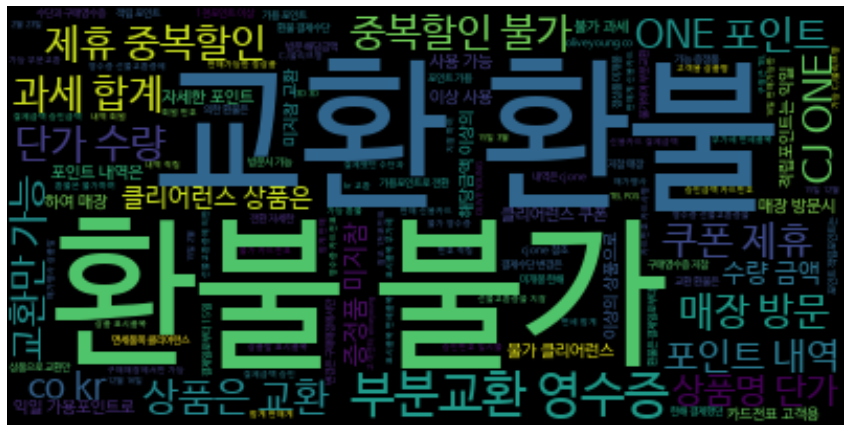

In [23]:
train_review = [review for review in train_data['document'] if type(review) is str]
wordcloud = WordCloud(font_path=fontpath).generate(' ' .join(train_review))
plt.figure(figsize = (15 , 10))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

### 기타

텍스트 문장에는 종종 문장의 끝의 기호가 마침표냐 물음표냐 등에 따라 텍스트가 어떤 의미를 가졌는지 대략 짐작을 할 때도 있습니다.

이 텍스트 데이터셋 같은 경우는 어떤지 한 번 보도록 합시다.

In [24]:
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x)) # 마침표
empty = np.mean(train_data['document'].astype(str).apply(lambda x: ' ' in x)) # 스페이스
                  
print('물음표가 있는 영수증: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 영수증: {:.2f}%'.format(fullstop * 100))
print('공백이 있는 영수증: {:.2f}%'.format(empty * 100))

물음표가 있는 영수증: 0.18%
마침표가 있는 영수증: 6.93%
공백이 있는 영수증: 91.90%


## 데이터 전처리

텍스트 분류기 모델 학습을 위해 데이터를 모델에 학습시킬 수 있도록 구성해주어야 합니다.

여기서는 텍스트 필터링과 토크나이징, 불용어처리 등을 다루고, 인덱싱처리를 통해 모델에 들어 갈 입력 데이터를 구성합니다.

### 잠깐! 용어 정리

- 배치(batch): 모델 학습에 한 번에 입력할 데이터셋

- 에폭(epoch): 모델 학습시 전체 데이터를 학습한 횟 수

- 스텝(step): (모델 학습의 경우) 하나의 배치를 학습한 횟 수

- 토큰(token): (여기서는) 문장 또는 문단의 기본 구성 단위 (예를 들어 단위, 형태소)

- 토크나이징(tokenizing): 문단 또는 문장 문자열을 하나의 토큰 단위로 쪼개는 작업

- 인덱싱(indexing): 토큰 문자열을 숫자(인덱스)로 변환하여 표현하는 작업

- 사전(vocabulary): 토큰 문자열과 인덱스의 관계를 정의해둔 셋

- n-그램(n-gram): 입력한 문자열을 N개의 기준 단위로 절단하는 방법

### 전처리를 위한 라이브러리

- konlpy: 형태소 단위로 토크나이징을 하기 위해 필요한 라이브러리 입니다.
- tensorflow.python.keras.preprocessing: 단어사전을 만들고 인덱싱을 위해 필요한 모듈입니다.
- tqdm: Progress Bar 라이브러리 입니다.

In [0]:
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

In [26]:
train_data.head(10)

,id,document,label
0,1,성북도 청주시 흥덕구 사운로 303,2
1,2,6098101574 구장고 TEL : 043- 260 - 15,3
2,3,2020- 02 - 29 20 : 17 : 29 POS : 1001 -00081 M...,4
3,4,고객센터 : 1577 - 4887 www .eliveyoung . co . KI,0
4,5,교환/ 환불은 결제일로부터 15일(3월 15일) 내,0
5,6,판매가능한 정상품( 미개봉) 에 한해 결제했던,0
6,7,수단과 구매영수증 지참 후 매장 방문시 가능,0
7,8,* 단 환불/ 결제수단 변경은 구매매장에서만,0
8,9,가능.,0
9,10,* 부분교환 영수증/선물교환중에 의한 환불은,0


### RegEx(정규표현식)를 활용한 텍스트 필터링

모델에서 다뤄야 할 단어가 너무 많아도 문제가 되는 경우가 있습니다.

이를 제어하기 위해 한글 데이터만을 받도록 regex를 통해 처리합니다.

* 영수증은 다뤄야 할 데이터에 영어가 포함되어 있는 경우도 있기 때문에 이 과정은 넘어가도록 하겠습니다.

### KoNLPy를 활용한 토크나이징

한글은 문장에서 단어들로 정의하여 분리하는게 쉽지 않습니다.

공백단위로 쪼개어 단어로 분리할 수 있기도 하지만 여기서는 형태소 분석기를 활용하여 단어로 분리해보도록 하겠습니다.

KoNLPy를 활용하여 토크나이징 하는 방법을 알아봅시다.

### 불용어 사전을 활용한 텍스트 필터링

### 위 세 과정을 세트로 하면...

In [0]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거. + 영어 소문자, 대문자, 숫자도 제외
    # 일단 OCR 결과의 원형을 학습시키기 위해 정규표현식을 사용하지 않고 학습시켜보겠습니다.
    #review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\\s]", "",  review)
    review_text = re.sub("", "",  review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [28]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '(', ')', '/', '*', '=', 'E', '|', '-', '.', ',']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

100%|██████████| 40000/40000 [00:37<00:00, 1077.32it/s]


### 전처리 결과 확인하기

전처리가 진행 된 후 얻어낸 clean_train_review가 어떻게 구성되어 있는지 확인해볼까요?

In [29]:
print(clean_train_review[1:10])

[['6098101574', '구장', '고', 'TEL', ':', '043', '260', '15'], ['2020', '02', '29', '20', ':', '17', ':', '29', 'POS', ':', '1001', '00081', 'M', '소'], ['고객', '센터', ':', '1577', '4887', 'www', 'eliveyoung', 'co', 'KI'], ['교환', '환불', '결제', '일로', '부터', '15일', '3월', '15일', '내'], ['판매', '가능하다', '정상품', '미개', '봉', '에', '한해', '결제', '하다'], ['수단', '과', '구매', '영수증', '지다', '차다', '후', '매장', '방문', '시', '가능'], ['단', '환불', '결제', '수단', '변경', '구', '매', '매장', '에서만'], ['가능'], ['부분', '교환', '영수증', '선물', '교환', '중', '에', '의하다', '환불']]


### 단어 사전 생성 및 인덱싱

이제 텍스트 데이터를 딥러닝 모델에 입력할 수 있도록 만들어 봅시다.

여기서는 케라스의 Tokenizer를 통해 단어 인덱싱 작업을 합니다.

다만 print(clean_train_review[1:10])에서 확인 할 수 있듯이 이미 필요한 내용은 토큰화가 잘 되어 있습니다. 그래서 각 단어를 정수에 인덱싱하고, 모든 단어의 길이를 max_len로 똑같게 만들어주는 작업만 진행하도록 하겠습니다.

In [0]:
# 케라스의 토크나이저 사용법
#from tensorflow.keras.preprocessing.text import Tokenizer
#t  = Tokenizer()
#fit_text = clean_train_review
#t.fit_on_texts([fit_text])

#test_text = clean_train_review
#sequences = t.texts_to_sequences([test_text])[0]

#print("sequences : ",sequences) # great는 단어 집합(vocabulary)에 없으므로 출력되지 않는다.
#print("word_index : ",t.word_index) # 단어 집합(vocabulary) 출력

### 정수 인코딩(Integer Encoding)

단어에 정수를 부여하는 방법 중 하나로 단어를 빈도수 순으로 정렬한 단어 집합(vocabulary)을 만들고, 빈도수가 높은 순서대로 차례로 낮은 숫자부터 정수를 부여하는 방법이 있습니다. 

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
sentences = clean_train_review

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.

fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여하는데, 정확히 앞서 설명한 정수 인코딩 작업이 이루어진다고 보면됩니다. 각 단어에 인덱스가 어떻게 부여되었는지를 보려면, word_index를 사용합니다.

In [34]:
print(tokenizer.word_index)

{'"': 1, '교환': 2, ':': 3, ']': 4, '포인트': 5, '[': 6, '1': 7, '환불': 8, '시': 9, '상품': 10, '결제': 11, '영수증': 12, '가능': 13, '금액': 14, '매장': 15, '불가': 16, '차다': 17, '카드': 18, '내': 19, '번호': 20, '에': 21, '000': 22, '하다': 23, '품목': 24, '방문': 25, '클리어': 26, '증': 27, '런스': 28, '이상': 29, '수단': 30, '지다': 31, '부분': 32, '역': 33, '선물': 34, '고객': 35, '2': 36, '적립': 37, 'cj': 38, '가용': 39, '판매': 40, '승인': 41, '세': 42, '가다': 43, '명': 44, 'www': 45, '부': 46, '할인': 47, '3': 48, '로': 49, '"[': 50, '매': 51, '쿠폰': 52, '구': 53, '면세': 54, '합계': 55, '**': 56, '제휴': 57, '15일': 58, '만': 59, '행사': 60, '해당': 61, '을': 62, '중복': 63, '올리브영': 64, '구매': 65, '수량': 66, 'tel': 67, '매가': 68, '변경': 69, '미개': 70, '계': 71, '미지': 72, '표시': 73, '단가': 74, '품': 75, '한해': 76, '증정': 77, '과': 78, '일로': 79, '의하다': 80, '과세': 81, '일': 82, '후': 83, 'co': 84, '용': 85, 'pos': 86, '1577': 87, '부터': 88, '봉': 89, '으로': 90, 'one': 91, '단': 92, '900': 93, '센터': 94, '에서만': 95, '사용': 96, 'kr': 97, '익일': 98, '자세하다': 99, '4887': 100, '신용카드': 101, '가

texts_to_sequences()는 입력으로 들어온 코퍼스에 대해서 각 단어를 이미 정해진 인덱스로 변환합니다.

In [35]:
print(tokenizer.texts_to_sequences(sentences))

[[3548, 369, 1149, 2165, 869, 3549], [574, 209, 204, 67, 3, 1070, 1834, 143], [132, 108, 225, 151, 3, 173, 3, 225, 86, 3, 153, 1590, 228, 339], [35, 94, 3, 87, 100, 45, 5580, 84, 1410], [2, 8, 11, 79, 88, 58, 164, 58, 19], [40, 102, 112, 70, 89, 21, 76, 11, 23], [30, 78, 65, 12, 31, 17, 83, 15, 25, 9, 13], [92, 8, 11, 30, 69, 53, 51, 15, 95], [13], [32, 2, 12, 34, 2, 329, 21, 80, 8], [107, 32, 2, 12, 34, 2, 27, 62, 31, 17], [23, 15, 25, 9, 61, 14, 29, 10, 90], [2, 59, 13], [77, 75, 72, 17, 9, 2, 8, 16], [26, 28, 10, 2, 8, 16], [], [18, 105, 35, 85], [], [10, 44, 74, 66, 161, 154], [7, 925, 712, 1411, 439, 480, 5581, 748, 68, 60], [1, 5582, 48, 22, 36, 124, 22, 1], [36, 129, 64, 271, 250, 123], [288, 123, 7, 123], [10, 118, 73, 24, 3, 46, 43, 42, 54, 24], [113, 26, 28, 52, 3, 57, 63, 47, 16, 1], [1, 81, 55, 117, 373, 1], [46, 43, 42, 344], [926, 357, 404, 54, 55, 2685, 3550, 123], [1, 40, 71, 1835, 1], [1, 85, 18, 124, 123, 1], [1, 11, 14, 1835, 1], [50, 41, 14, 4, 124, 123, 1], [6, 18,

앞서 빈도수가 가장 높은 단어 n개만을 사용하기 위해서 most_common()을 사용했었습니다. 케라스 토크나이저에서는 tokenizer = Tokenizer(num_words=숫자)와 같은 방법으로 빈도수가 높은 상위 몇 개의 단어만 사용하겠다고 지정할 수 있습니다. 여기서는 1번 단어부터 15000번 단어까지만 사용하겠습니다. 상위 15000개 단어를 사용한다고 토크나이저를 재정의 해보겠습니다.

In [0]:
max_features = 15000
text_max_words = 120

In [0]:
#vocab_size=15000
#tokenizer = Tokenizer(num_words=vocab_size+1) # 상위 10000개 단어만 사용
tokenizer = Tokenizer(num_words=max_features+1)
tokenizer.fit_on_texts(sentences)

In [38]:
print(tokenizer.texts_to_sequences(sentences))

[[3548, 369, 1149, 2165, 869, 3549], [574, 209, 204, 67, 3, 1070, 1834, 143], [132, 108, 225, 151, 3, 173, 3, 225, 86, 3, 153, 1590, 228, 339], [35, 94, 3, 87, 100, 45, 5580, 84, 1410], [2, 8, 11, 79, 88, 58, 164, 58, 19], [40, 102, 112, 70, 89, 21, 76, 11, 23], [30, 78, 65, 12, 31, 17, 83, 15, 25, 9, 13], [92, 8, 11, 30, 69, 53, 51, 15, 95], [13], [32, 2, 12, 34, 2, 329, 21, 80, 8], [107, 32, 2, 12, 34, 2, 27, 62, 31, 17], [23, 15, 25, 9, 61, 14, 29, 10, 90], [2, 59, 13], [77, 75, 72, 17, 9, 2, 8, 16], [26, 28, 10, 2, 8, 16], [], [18, 105, 35, 85], [], [10, 44, 74, 66, 161, 154], [7, 925, 712, 1411, 439, 480, 5581, 748, 68, 60], [1, 5582, 48, 22, 36, 124, 22, 1], [36, 129, 64, 271, 250, 123], [288, 123, 7, 123], [10, 118, 73, 24, 3, 46, 43, 42, 54, 24], [113, 26, 28, 52, 3, 57, 63, 47, 16, 1], [1, 81, 55, 117, 373, 1], [46, 43, 42, 344], [926, 357, 404, 54, 55, 2685, 3550, 123], [1, 40, 71, 1835, 1], [1, 85, 18, 124, 123, 1], [1, 11, 14, 1835, 1], [50, 41, 14, 4, 124, 123, 1], [6, 18,

In [0]:
train_sequences = tokenizer.texts_to_sequences(sentences)
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

In [40]:
train_labels

array([ 2,  3,  4, ...,  0,  0, 12])



### 패딩 작업

여러분이 만약에 모델학습을 하게된다면 학습데이터를 한 문장씩 입력하여 학습하지 않습니다. 
여러 문장을 한번에 묶어서 모델에 입력하게 되는데 이 입력하는 데이터 입력 셋 단위를 '배치'라 합니다.

여러 문장 데이터를 하나의 배치로 구성하게 되면 각 문장의 길이가 각각 다르게 되어 있는걸 확인 하실 수 있습니다.
하지만, 각 문장 입력 데이터 길이가 다르다면 모델 연산을 하는데 문제가 생깁니다. 
왜냐하면 모델은 입력 사이즈가 고정되어 연산되는 걸 선호하기 때문에 그렇습니다.

이러한 문제 때문에 가급적 고정된 문장 길이를 정해두고 입력 문장의 길이를 맞추는 것이 가장 좋습니다.
문장이 긴 경우에는 고정된 문장 길이만큼 자르면 되지만 짧은 경우에는 그렇지 않습니다.
패딩 작업은 이러한 짧은 문장에 대해서 '<PAD\>'와 같은 토큰을 길이를 맞추는 작업입니다.

여기서는 간단하게 pad_sequences 함수가 고정된 길이 만큼의 각 문장 데이터 길이를 맞춰줍니다.

pad_sequence() : 전체 훈련 데이터에서 각 샘플의 길이는 서로 다를 수 있습니다. 또는 각 문서 또는 각 문장은 단어의 수가 제각각입니다. 모델의 입력으로 사용하려면 모든 샘플의 길이를 동일하게 맞추어야할 때가 있습니다. 이를 자연어 처리에서는 패딩(padding) 작업이라고 하는데, 보통 숫자 0을 넣어서 길이가 다른 샘플들의 길이를 맞춰줍니다. 케라스에서는 pad_sequence()를 사용합니다. pad_sequence()는 정해준 길이보다 길이가 긴 샘플은 값을 일부 자르고, 정해준 길이보다 길이가 짧은 샘플은 값을 0으로 채웁니다.

* 위에서 문장 길이를 확인해봤듯이 최대 길이는 121, 평균 길이는 19였습니다. 영수증의 한 문장이 중간에서 짤리지 않도록 여유롭게 60으로 설정해주었습니다.



In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_inputs =  pad_sequences(train_sequences, maxlen=120, padding='post') # 학습 데이터를 벡터화
print(train_inputs)
# 전처리가 끝나서 각 단어에 대한 정수 인코딩이 끝났다고 가정

[[3548  369 1149 ...    0    0    0]
 [ 574  209  204 ...    0    0    0]
 [ 132  108  225 ...    0    0    0]
 ...
 [  81   55    0 ...    0    0    0]
 [ 910    0    0 ...    0    0    0]
 [ 181  190    0 ...    0    0    0]]


### 이로써 영수증 OCR 결과 텍스트를 
1. 분석해보고, 
2. 정규표현식과 불용어를 통해 텍스트를 필터링하고, 
3. KoNLPy를 활용해 토크나이징하고, 
4. 전처리 결과를 확인해보고
5. 단어 사전을 만들고 정수로 변환해 인덱싱했으며,
6. 모델에 입력시키기 위해 모든 문장의 길이를 60으로 맞춰주었습니다.

드디어 모델을 사용하기 위한 데이터의 준비가 끝났다고 보면 됩니다.
이제 모델을 만들어볼까요?

## 모델 학습을 위한 준비

### 1) 데이터의 분리(Splitting Data)

1. 지도학습(Supervised Learning)
지도 학습의 훈련 데이터는 문제지를 연상케 합니다. 지도 학습의 훈련 데이터는 정답이 무엇인지 맞춰 하는 '문제'에 해당되는 데이터와 레이블이라고 부르는 '정답'이 적혀있는 데이터로 구성되어 있습니다. 쉽게 비유하면, 기계는 정답이 적혀져 있는 문제지를 문제와 정답을 함께 보면서 열심히 공부하고, 향후에 정답이 없는 문제에 대해서도 정답을 잘 예측해야 합니다.

앞에서 전처리한 데이터의 결과물로 보면
문제 : train_inputs
정답 : train_labels
입니다.

In [42]:
len(train_inputs)

40000

In [43]:
len(train_labels)

40000

이해를 쉽게 하기위해서 우리는 기계를 지도하는 선생님의 입장이 되어보겠습니다. 기계를 가르치기 위해서 데이터를 총 4개로 나눕니다. 우선 메일의 내용이 담긴 첫번째 열을 X에 저장합니다. 그리고 메일이 스팸인지 정상인지 정답이 적혀있는 두번째 열을 y에 저장합니다. 이제 문제지에 해당되는 20,000개의 X와 정답지에 해당되는 20,000개의 y가 생겼습니다.

그리고 이제 이 X와 y에 대해서 일부 데이터를 또 다시 분리합니다. 이는 문제지를 다 공부하고나서 실력을 평가하기 위해서 시험(Test)용으로 일부로 일부 문제와 정답지를 빼놓는 것입니다. 여기서는 2,000개를 분리한다고 가정하겠습니다. 이 때, 분리시에는 여전히 X와 y의 맵핑 관계를 유지해야 합니다. 어떤 X(문제)에 대한 어떤 y(정답)인지 바로 찾을 수 있어야 합니다. 이렇게 되면 학습용에 해당되는 18,000개의 X, y의 쌍과 시험용에 해당되는 2000개의 X, y의 쌍이 생깁니다 이 책에서는 이러한 유형의 데이터들에게 주로 이러한 변수명을 부여합니다.

<훈련 데이터>

X_train : 문제지 데이터

y_train : 문제지에 대한 정답 데이터.

<테스트 데이터>

X_test : 시험지 데이터.

y_test : 시험지에 대한 정답 데이터.

기계는 이제부터 X_train과 y_train에 대해서 학습을 합니다. 기계는 현 상태에서는 정답지인 y_train을 볼 수 있기 때문에 18,000개의 문제지 X_train을 보면서 어떤 메일 내용일 때 정상 메일인지 스팸 메일인지를 열심히 규칙을 도출해나가면서 정리해나갑니다. 그리고 학습을 다 한 기계에게 y_test는 보여주지 않고, X_test에 대해서 정답을 예측하게 합니다. 그리고 기계가 예측한 답과 실제 정답인 y_test를 비교하면서 기계가 정답을 얼마나 맞췄는지를 평가합니다. 이 수치가 기계의 정확도(Accuracy)가 됩니다.

### 2) X와 y분리하기

1. zip 함수를 이용하여 분리하기
2. 데이터 프레임을 이용하여 분리하기
3. Numpy를 이용하여 분리하기
이번엔 zip함수를 이용해 분리해보도록 하겠습니다.

zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다. 리스트의 리스트 구성에서 zip 함수는 X와 y를 분리하는데 유용합니다. 우선 zip 함수가 어떤 역할을 하는지 확인해보도록 하겠습니다.

X,y = zip(['a', 1], ['b', 2], ['c', 3])

print(X)

print(y)

=>

('a', 'b', 'c')

(1, 2, 3)

각 데이터에서 첫번째로 등장한 원소들끼리 묶이고, 두번째로 등장한 원소들끼리 묶인 것을 볼 수 있습니다. 

다만 위의 방법들은 처음에 train_data(csv, txt파일)에 대해서 각 열을 나눌 때 유용한 것입니다. 

다음으로 이미 X와 y가 분리된 데이터에 대해서 테스트 데이터를 분리하는 과정에 대해서 알아보도록 하겠습니다.

### 3) 테스트 데이터 분리하기(이미 X와 y가 분리된 데이터)

- 사이킷 런을 이용하여 분리하기

여기서는 훈련 데이터와 테스트 데이터를 유용하게 나눌 수 있는 하나의 방법을 소개합니다. 사이킷 런은 학습용 테스트와 테스트용 데이터를 분리하게 해주는 train_test_split를 지원합니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1234)

X : 독립 변수 데이터. (배열이나 데이터프레임)

y : 종속 변수 데이터. 레이블 데이터.

test_size : 테스트용 데이터 개수를 지정한다. 1보다 작은 실수를 기재할 경우, 비율을 나타낸다.

train_size : 학습용 데이터의 개수를 지정한다. 1보다 작은 실수를 기재할 경우, 비율을 나타낸다.

(test_size와 train_size 중 하나만 기재해도 가능)

random_state : 난수 시드

아래에 예를 들어보겠습니다.

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), range(5)
# 실습을 위해 임의로 X와 y가 이미 분리 된 데이터를 생성
print(X)
print(list(y)) #레이블 데이터

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[0, 1, 2, 3, 4]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)
#3분의 1만 test 데이터로 지정.
#random_state 지정으로 인해 순서가 섞인 채로 훈련 데이터와 테스트 데이터가 나눠진다.

In [46]:
print(X_train)
print(X_test)

[[2 3]
 [4 5]
 [6 7]]
[[8 9]
 [0 1]]


In [47]:
print(y_train)
print(y_test)

[1, 2, 3]
[4, 0]


이제 실제로 전처리 한 영수증 데이터를 훈련 데이터와 테스트 데이터로 나눠보도록 합시다.

In [0]:
input_data = train_inputs
label_data = train_labels
word_index = tokenizer.word_index

#### 하이퍼파라메터 설정

아래 상수들은 모델에 필요한 하이퍼파라메터 값들입니다.

하이퍼파라메터는 다음과 같이 구성되어 있습니다.

- TEST_SPLIT : 전체 데이터 중 얼마나 평가 데이터로 활용할 지 정하는 상수(0~1)

- RNG_SEED : 데이터 분리를 하는데 랜덤 생성 시드 번호를 고정해두는 상수

- VOCAB_SIZE : 단어 임베딩 총 단어수에 대한 상수

- EMB_SIZE : 단어 임베딩 및 CNN 네트워크 출력 임베딩 차원에 대한 상수

- BATCH_SIZE : 학습 시 모델에 한 번 입력할 데이터 양, 배치 사이즈 상수

- NUM_EPOCHS: 전체 데이터를 몇 번 학습 시킬 것인지 정하는(에포크)) 상수

In [0]:
TEST_SPLIT = 0.2
RNG_SEED = 123
VOCAB_SIZE = len(word_index)+1
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 1

In [50]:
word_index

{'"': 1,
 '교환': 2,
 ':': 3,
 ']': 4,
 '포인트': 5,
 '[': 6,
 '1': 7,
 '환불': 8,
 '시': 9,
 '상품': 10,
 '결제': 11,
 '영수증': 12,
 '가능': 13,
 '금액': 14,
 '매장': 15,
 '불가': 16,
 '차다': 17,
 '카드': 18,
 '내': 19,
 '번호': 20,
 '에': 21,
 '000': 22,
 '하다': 23,
 '품목': 24,
 '방문': 25,
 '클리어': 26,
 '증': 27,
 '런스': 28,
 '이상': 29,
 '수단': 30,
 '지다': 31,
 '부분': 32,
 '역': 33,
 '선물': 34,
 '고객': 35,
 '2': 36,
 '적립': 37,
 'cj': 38,
 '가용': 39,
 '판매': 40,
 '승인': 41,
 '세': 42,
 '가다': 43,
 '명': 44,
 'www': 45,
 '부': 46,
 '할인': 47,
 '3': 48,
 '로': 49,
 '"[': 50,
 '매': 51,
 '쿠폰': 52,
 '구': 53,
 '면세': 54,
 '합계': 55,
 '**': 56,
 '제휴': 57,
 '15일': 58,
 '만': 59,
 '행사': 60,
 '해당': 61,
 '을': 62,
 '중복': 63,
 '올리브영': 64,
 '구매': 65,
 '수량': 66,
 'tel': 67,
 '매가': 68,
 '변경': 69,
 '미개': 70,
 '계': 71,
 '미지': 72,
 '표시': 73,
 '단가': 74,
 '품': 75,
 '한해': 76,
 '증정': 77,
 '과': 78,
 '일로': 79,
 '의하다': 80,
 '과세': 81,
 '일': 82,
 '후': 83,
 'co': 84,
 '용': 85,
 'pos': 86,
 '1577': 87,
 '부터': 88,
 '봉': 89,
 '으로': 90,
 'one': 91,
 '단': 92,
 '900': 93,

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

input_train, input_test, label_train, label_test = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)
#20%의 데이터를 테스트 데이터로 활용하도록 하겠습니다.

In [52]:
len(input_train)

32000

In [53]:
len(label_train)

32000

In [54]:
len(input_test)

8000

In [55]:
len(label_test)

8000

훈련에 사용할 32000개의 문장:레이블과 테스트에 사용할 8000개의 문장:레이블이 잘 나뉜 것을 확인 할 수 있습니다!

각 샘플은 영수증 한 문장을 의미하며, 단어의 인덱스로 구성되어 있습니다. 

훈련셋 32000개 중 다시 28000개을 훈련셋으로 나머지를 검증셋으로 분리합니다.

### 4) 훈련셋에서 검증셋 분리하기

In [0]:
input_val = input_train[28000:]
label_val = label_train[28000:]
input_train = input_train[:28000]
label_train = label_train[:28000]

In [57]:
print(len(input_train),len(label_train),': 훈련용 데이터/라벨','\n',len(input_val),len(label_val),': 검증용 데이터/라벨','\n',len(input_test),len(label_test),': 테스트용 데이터/라벨')

28000 28000 : 훈련용 데이터/라벨 
 4000 4000 : 검증용 데이터/라벨 
 8000 8000 : 테스트용 데이터/라벨


In [58]:
input_train

array([[   2,    8,   11, ...,    0,    0,    0],
       [ 637, 1403, 1546, ...,    0,    0,    0],
       [  86,    7,    0, ...,    0,    0,    0],
       ...,
       [ 127,  209,  135, ...,    0,    0,    0],
       [  23,   15,   25, ...,    0,    0,    0],
       [  77,   75,   72, ...,    0,    0,    0]], dtype=int32)

In [59]:
label_train

array([0, 2, 0, ..., 3, 0, 0])

모델 학습에 사용할 패키지를 불러오겠습니다.

In [0]:
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

### 5) 문장 길이 맞추기

In [0]:
# 데이터셋 전처리 : 문장 길이 맞추기
input_train = sequence.pad_sequences(input_train, maxlen=text_max_words)
input_val = sequence.pad_sequences(input_val, maxlen=text_max_words)
input_test = sequence.pad_sequences(input_test, maxlen=text_max_words)

#ndarray with shape(16000,120) : input_train
#ndarray with shape(2000,120) : input_val
#ndarray with shape(2000,120) : input_test

In [62]:
print('데이터 텐서의 크기:', input_train)

데이터 텐서의 크기: [[   2    8   11 ...    0    0    0]
 [ 637 1403 1546 ...    0    0    0]
 [  86    7    0 ...    0    0    0]
 ...
 [ 127  209  135 ...    0    0    0]
 [  23   15   25 ...    0    0    0]
 [  77   75   72 ...    0    0    0]]


### 6) 원핫 인코딩

In [0]:
# one-hot 인코딩
label_train = np_utils.to_categorical(label_train)
label_val = np_utils.to_categorical(label_val)
label_test = np_utils.to_categorical(label_test)

#ndarray with shape(16000, ) : label_train

In [64]:
print('레이블 텐서의 크기:', label_train)

레이블 텐서의 크기: [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


굵은 텍스트### 레이어 준비(용어)

1. Embedding : 단어를 의미론적 기하공간에 매핑할 수 있도록 벡터화시킵니다.
2. Conv1D : 필터를 이용하여 지역적이 특징을 추출합니다.
3. GlobalMaxPooling1D : 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환합니다.
4. MaxPooling1D : 일력벡터에서 특정 구간마다 값을 골라 벡터를 구성한 후 반환합니다.

### 모델 준비(설명 섹터)

문장을 입력하여 다중클래스 분류를 하기 위해 
- 다층퍼셉트론 신경망 모델(MPN)
- 순환 신경망 모델(RNN)
- 컨볼루션 신경망 모델(CNN)
- 순환 컨볼루션 신경망(RCNN) 모델을 준비했습니다.

#### 임베딩 레이어에 대하여

먼저 임베딩(Embedding) 레이어에 대해서 알아보겠습니다. 임베딩 레이어의 인자 의미는 다음과 같습니다.

- 첫번째 인자(input_dim) : 단어 사전의 크기를 말하며 총 20,000개의 단어 종류가 있다는 의미입니다. 이 값은 앞서 imdb.load_data() 함수의 num_words 인자값과 동일해야 합니다.

- 두번째 인자(output_dim) : 단어를 인코딩 한 후 나오는 벡터 크기 입니다. 이 값이 128이라면 단어를 128차원의 의미론적 기하공간에 나타낸다는 의미입니다. 단순하게 빈도수만으로 단어를 표시한다면, 10과 11은 빈도수는 비슷하지만 단어로 볼 때는 전혀 다른 의미를 가지고 있습니다. 하지만 의미론적 기하공간에서는 거리가 가까운 두 단어는 의미도 유사합니다. 즉 임베딩 레이어는 입력되는 단어를 의미론적으로 잘 설계된 공간에 위치시켜 벡터로 수치화 시킨다고 볼 수 있습니다.

- input_length : 단어의 수 즉 문장의 길이를 나타냅니다. 임베딩 레이어의 출력 크기는 샘플 수 * output_dim * input_lenth가 됩니다. 임베딩 레이어 다음에 Flatten 레이어가 온다면 반드시 input_lenth를 지정해야 합니다. 플래튼 레이어인 경우 입력 크기가 알아야 이를 1차원으로 만들어서 Dense 레이어에 전달할 수 있기 때문입니다.

아래는 임베딩 레이어로 인코딩한 후 Dense 레이어를 통해 분류하는 다층퍼셉트론 신경망 모델입니다.

#### 다층퍼셉트론 신경망 모델(MPNN)

임베딩 레이어는 0에서 14의 정수값으로 지정된 단어를 128벡터로 인코딩합니다. 문장의 길이가 120이므로 임베딩 레이어는 128 속성을 가진 벡터를 120개 반환합니다. 이를 플래튼 레이어를 통해 1차원 벡터로 만든 뒤 전결합층으로 전달합니다. 46개 주제를 분류해야 하므로 출력층의 활성화 함수로 ‘softmax’를 사용하였습니다.

In [0]:
model = Sequential()
model.add(Embedding(15000, 128, input_length=120))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(15, activation='softmax')) # 카테고리는 0부터 14까지 존재합니다.

#### 순환 신경망 모델(RNN)

문장을 단어들의 시퀀스로 간주하고 순환(LSTM) 레이어의 입력으로 구성한 모델입니다. 임베딩 레이어 다음에 LSTM 레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없습니다. 입력 문장의 길이에 따라 input_length가 자동으로 정해지고, 이것이 LSTM 레이어에는 timesteps으로 입력되기 때문입니다. 블록으로 표현한다면 예제에서는 문장의 길이가 200 단어이므로, LSTM 블록 200개가 이어져있다고 생각하면 됩니다.

임베딩 레이어에서 반환되는 120개 벡터를 LSTM의 타입스텝으로 입력하는 모델입니다. LSTM의 input_dim은 임베딩 레이어에서 인코딩된 벡터크기인 128입니다.


In [0]:
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
model.add(Embedding(15000, 128))
model.add(LSTM(128))
model.add(Dense(15, activation='softmax'))

#### 컨볼루션 신경망 모델(CNN)

문장 해석에 컨볼루션(Conv1D) 레이어를 이용한 모델입니다. 컨볼루션(Conv1D) 레이어는 위치에 상관없이 지역적인 특징을 잘 뽑아냅니다. 이 레이어를 문장에 적용한다면 주요 단어가 문장 앞 혹은 문장 뒤에 있더라도 놓치지 않고 전후 문맥을 보면서 특징을 잘 뽑아낼 수 있습니다. 글로벌 맥스풀링(GlobalMaxPooling1D) 레이어는 컨볼루션 레이어가 문장을 훑어가면서 나온 특징벡터들 중 가장 큰 벡터를 골라줍니다. 즉 문맥을 보면서 주요 특징을 뽑아내고, 그 중 가장 두드러지는 특징을 고르는 것입니다.

임베딩 레이어에서 반환되는 60개 벡터를 컨볼루션 필터를 적용한 모델입니다. 필터크기가 3인 컨볼루션 레이어는 60개의 벡터를 입력받아 58개의 벡터를 반환합니다. 벡터 크기는 컨볼루션 레이어를 통과하면서 128개에서 256개로 늘어났습니다. 글로벌 맥스풀링 레이어는 입력되는 58개 벡터 중 가장 큰 벡터 하나를 반환합니다. 그 벡터 하나를 전결합층을 통해서 다중클래스를 분류합니다.


In [0]:
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(15000, 128, input_length=120))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))

#### 순환 컨볼루션 신경망 모델

컨볼루션 레이어에서 나온 특징벡터들을 맥스풀링를 통해 1/4로 줄여준 다음 LSTM의 입력으로 넣어주는 모델입니다. 컨볼루션 레이어에서 반환한 58개의 벡터를 1/4로 줄여서 14개를 반환합니다. 따라서 LSTM 레이어의 timesteps는 49개가 됩니다. 참고로 input_dim은 60입니다.

In [0]:
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

odel = Sequential()
model.add(Embedding(15000, 128, input_length=120))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(15, activation='softmax'))

## 컨볼루션 신경망 모델 학습하기(CNN)

In [0]:
model = Sequential()
model.add(Embedding(15000, 128, input_length=120)) # 임베딩층의 출력 크기는 (max_features, input_length, 차원개수)가 됩니다.
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 2,053,519
Trainable params: 2,053,519
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# 4. 모델 학습시키기
hist = model.fit(input_train, label_train, epochs=10, batch_size=64, validation_data=(input_val, label_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 28000 samples, validate on 4000 samples
Epoch 1/10





28000/28000 [==============================] - 96s 3ms/step - loss: 1.4177 - acc: 0.6936 - val_loss: 1.4151 - val_acc: 0.6890
Epoch 2/10
28000/28000 [==============================] - 87s 3ms/step - loss: 1.3912 - acc: 0.6951 - val_loss: 1.4110 - val_acc: 0.6890
Epoch 3/10
28000/28000 [==============================] - 87s 3ms/step - loss: 1.3906 - acc: 0.6951 - val_loss: 1.4129 - val_acc: 0.6890
Epoch 4/10
28000/28000 [==============================] - 88s 3ms/step - loss: 1.3909 - acc: 0.6951 - val_loss: 1.4122 - val_acc: 0.6890
Epoch 5/10
28000/28000 [==============================] - 87s 3ms/step - loss: 1.3898 - acc: 0.6951 - val_loss: 1.4131 - val_acc: 0.6890
Epoch 6/10
28000/28000 [==============================] - 86s 3ms/step - loss: 1.3899 - acc: 0.6951 - val_loss: 1.4133 - val_acc: 0.6890
Epoch 7/10
28000/28000 [===

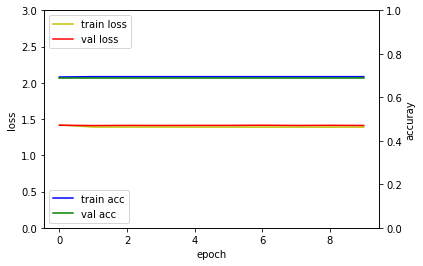

In [69]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [70]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(input_test, label_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

8000/8000 [==============================] - 4s 550us/step
## evaluation loss and_metrics ##
[1.3501951489448547, 0.70625]


짜잔!! 
- 훈련용 데이터와 검증용 데이터에서의 정확도는 다음과 같습니다.

loss: 0.0244 - acc: 0.9936 - val_loss: 0.2782 - val_acc: 0.9460

- 테스트 데이터의 각 문장에 대해 카테고리 예측 정확도는 다음과 같습니다.

[loss : 0.20985758835077287, metrics(acc) : 0.9525]

95% 확률로 훈련되지 않은 영수증 OCR 결과 문장에 적합한 15개의 카테고리 중 하나를 정확하게 예측하는 모델을 만들었습니다.

하지만 이것은 전체적인 정확도인데요, 각 카테고리(클래스) 별로 얼마나 정확하게 예측할 수 있는지 궁금하니까 시각화해보도록 할까요?
우리에게 불필요한 0번 카테고리만 정확하게 분류해내면 쓸모가 없으니까 확인해보도록 합시다.


## 다층 퍼셉트론 신경망 모델 학습하기

In [62]:
model = Sequential()
model.add(Embedding(15000, 128, input_length=120))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(15, activation='softmax')) # 카테고리는 0부터 14까지 존재합니다.

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          1920000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dense_2 (Dense)              (None, 15)                3855      
Total params: 5,856,271
Trainable params: 5,856,271
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# 4. 모델 학습시키기
hist = model.fit(input_train, label_train, epochs=15, batch_size=64, validation_data=(input_val, label_val))

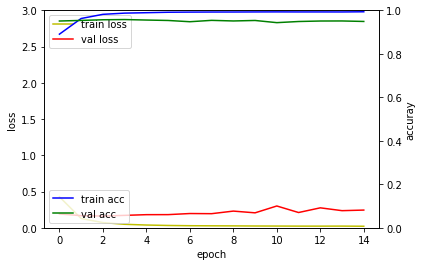

In [66]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [67]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(input_test, label_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

8000/8000 [==============================] - 0s 27us/step
## evaluation loss and_metrics ##
[0.24829915380477904, 0.945375]


## 각 카테고리 별 훈련결과 시각화

* 정확도를 평가할 때는 클래스의 분포도를 꼭 확인하여야 합니다. 예를 들어 남자고등학교에서 남녀를 구분하는 모델을 개발한다고 했을 때, 그 모델이 무조건 남자인 결과를 내놓는다고 가정해봅시다. 실제 여자가 있더라도 모두 남자라고 분류를 하겠지만 정확도는 90% 넘을 겁니다. 그렇다고 이 모델이 좋은 모델이라고 할 수는 없죠. 위에서 봤듯이 영수증 CNN 결과는 99%가 넘습니다. 테스트 모델에 적용해봐도 95%가 나옵니다. 하지만 이 모델 클래스는 극단적으로 0이 많습니다. 0은 불필요 카테고리인데 불필요한 것을 불필요하다고 맞추는 것이 크게 중요하지는 않습니다. 나머지 14개의 카테고리에 해당하는 문장을 정확히 찾아낼 수 있는가가 중요하지요. 

### 특정 클래스에 대한 정밀도,재현율 구현 함수
- 검출 및 검색 하기

분류문제에 대해서는 정밀도와 재현율이라는 판단 기준을 사용합니다.
* 정밀도 = 실제 양성 수 / 양성이라고 판정한 수

정밀도는 모델이 얼마나 정밀한가?입니다. 즉 진짜 양성만을 잘 고를 수록 정밀도가 높습니다.

- 재현율 = 검출 양성 수 / 전체 양성 수  
재현율은 양성인 것을 놓치지 않고 골라내는가?입니다. 양성을 많이 고를수록 재현율이 높습니다.

또한 확률값을 판정하기 위한 판정 기준을 임계값(Threshold)라고 합니다. 임계값이 0%, 10%, 20% ... 처럼 변함에 따라 확률값도 함께 변한다는 것을 알아야합니다.

그래서 임계값에 변화에 따른 판단 결과를 그래프로 쉽게 나타내서 어느 지점의 인계값이 가장 정밀도와 재현율이 모두 좋은가를 판단할 수 있는데 이 때 사용하는 것이
Precision-Recall Graph입니다.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras import backend as K

In [0]:
# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1) # y_true: 실제 값, 티아노 및 텐스플로우의 텐서(tensor)
        class_id_pred = K.argmax(y_pred, axis=-1) # y_pred: 예측 값, 티아노 및 텐스플로우의 텐서(tensor)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

In [0]:
# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall


특정 클래스에 대한 정밀도가 재현율을 구하기 위한 함수입니다.

### 모델 구성하기
이제 모델을 구성하고 사용하는 코드를 작성할건데, CNN을 비롯한 RNN, RCNN 등의 결과도 궁금하니 아래의 스크립트는 모델 구성에 맞게 변경하여 사용하시길 바랍니다.

In [59]:
# 2. 모델 구성하기(rNN)
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
model.add(Embedding(15000, 128))
model.add(LSTM(128))
model.add(Dense(15, activation='softmax'))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 2,053,519
Trainable params: 2,053,519
Non-trainable params: 0
_________________________________________________________________


### 모델 학습과정 설정하기

In [61]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9),
                       single_class_precision(10), single_class_recall(10),
                       single_class_precision(11), single_class_recall(11),
                       single_class_precision(12), single_class_recall(12),
                       single_class_precision(13), single_class_recall(13),
                       single_class_precision(14), single_class_recall(14)])

### 모델 학습시키기

In [62]:
# 4. 모델 학습시키기
hist = model.fit(input_train, label_train, epochs=10, batch_size=64, validation_data=(input_val, label_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 28000 samples, validate on 4000 samples
Epoch 1/10





28000/28000 [==============================] - 82s 3ms/step - loss: 1.5382 - acc: 0.6938 - prec: 0.6938 - recall: 0.9977 - prec_1: 0.0000e+00 - recall_1: 0.0000e+00 - prec_2: 0.0000e+00 - recall_2: 0.0000e+00 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - prec_6: 0.0000e+00 - recall_6: 0.0000e+00 - prec_7: 3.5714e-05 - recall_7: 0.0023 - prec_8: 0.0000e+00 - recall_8: 0.0000e+00 - prec_9: 0.0000e+00 - recall_9: 0.0000e+00 - prec_10: 0.0000e+00 - recall_10: 0.0000e+00 - prec_11: 0.0000e+00 - recall_11: 0.0000e+00 - prec_12: 0.0000e+00 - recall_12: 0.0000e+00 - prec_13: 0.0000e+00 - recall_13: 0.0000e+00 - prec_14: 0.0000e+00 - recall_14: 0.0000e+00 - val_loss: 1.4183 - val_acc: 0.6890 - val_prec: 0.6890 - val_recall: 1.0000 - val_prec_1: 0.00

KeyboardInterrupt: ignored

### 학습과정 살펴보기

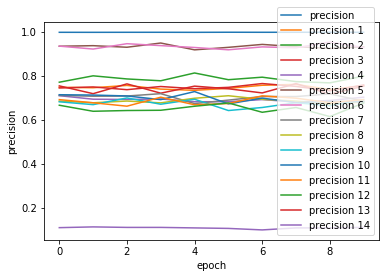

In [74]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec'], label='precision')
plt.plot(hist.history['prec_1'], label='precision 1')
plt.plot(hist.history['prec_2'], label='precision 2')
plt.plot(hist.history['prec_3'], label='precision 3')
plt.plot(hist.history['prec_4'], label='precision 4')
plt.plot(hist.history['prec_5'], label='precision 5')
plt.plot(hist.history['prec_6'], label='precision 6')
plt.plot(hist.history['prec_7'], label='precision 7')
plt.plot(hist.history['prec_8'], label='precision 8')
plt.plot(hist.history['prec_9'], label='precision 9')
plt.plot(hist.history['prec_10'], label='precision 10')
plt.plot(hist.history['prec_11'], label='precision 11')
plt.plot(hist.history['prec_12'], label='precision 12')
plt.plot(hist.history['prec_13'], label='precision 13')
plt.plot(hist.history['prec_14'], label='precision 14')

plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

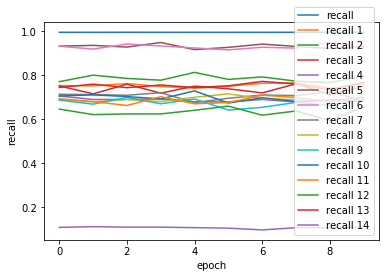

In [75]:
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['recall_1'], label='recall 1')
plt.plot(hist.history['recall_2'], label='recall 2')
plt.plot(hist.history['recall_3'], label='recall 3')
plt.plot(hist.history['recall_4'], label='recall 4')
plt.plot(hist.history['recall_5'], label='recall 5')
plt.plot(hist.history['recall_6'], label='recall 6')
plt.plot(hist.history['recall_7'], label='recall 7')
plt.plot(hist.history['recall_8'], label='recall 8')
plt.plot(hist.history['recall_9'], label='recall 9')
plt.plot(hist.history['recall_10'], label='recall 10')
plt.plot(hist.history['recall_11'], label='recall 11')
plt.plot(hist.history['recall_12'], label='recall 12')
plt.plot(hist.history['recall_13'], label='recall 13')
plt.plot(hist.history['recall_14'], label='recall 14')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

### 모델 평가하기

8000/8000 [==============================] - 1s 114us/step
## evaluation loss and_metrics ##
[0.24052405374497174, 0.949, 0.9592683200836182, 0.9803336777687073, 0.7253333339691163, 0.7226666669845581, 0.7204000005722045, 0.6805904774665833, 0.6004000010490418, 0.5986666679382324, 0.6473333339691162, 0.6566666669845581, 0.851333333492279, 0.8270000004768372, 0.856800000667572, 0.82872381067276, 0.602, 0.587333333492279, 0.5486666669845581, 0.5546666669845581, 0.6120000004768371, 0.603333333492279, 0.7104000005722045, 0.7193333337306976, 0.5913333339691162, 0.609333333492279, 0.192, 0.15133333373069763, 0.6580000004768372, 0.6780000004768372, 0.11733333349227905, 0.12]


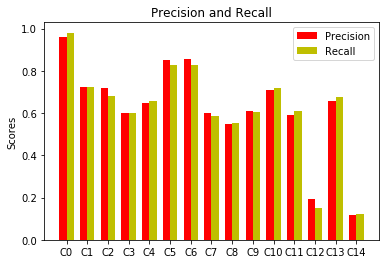

In [76]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(input_test, label_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

import numpy as np

metrics = np.array(loss_and_metrics[2:32])
idx = np.linspace(0, 29, num=30) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 15
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

In [77]:
loss_and_metrics

[0.24052405374497174,
 0.949,
 0.9592683200836182,
 0.9803336777687073,
 0.7253333339691163,
 0.7226666669845581,
 0.7204000005722045,
 0.6805904774665833,
 0.6004000010490418,
 0.5986666679382324,
 0.6473333339691162,
 0.6566666669845581,
 0.851333333492279,
 0.8270000004768372,
 0.856800000667572,
 0.82872381067276,
 0.602,
 0.587333333492279,
 0.5486666669845581,
 0.5546666669845581,
 0.6120000004768371,
 0.603333333492279,
 0.7104000005722045,
 0.7193333337306976,
 0.5913333339691162,
 0.609333333492279,
 0.192,
 0.15133333373069763,
 0.6580000004768372,
 0.6780000004768372,
 0.11733333349227905,
 0.12]

다층퍼센트론 신경망 모델(MLP) 각 클래스 별 정밀도, 재현율 그래프로 구현한 결과

- 0번 클래스 > 정밀도 : 0.95 / 재현율 : 0.99 (불필요)

- 1번 클래스 > 정밀도 : 0.66 / 재현율 : 0.65 (브랜드명, 지점명)

- 2번 클래스 > 정밀도 : 0.87 / 재현율 : 0.80 (주소)

- 3번 클래스 > 정밀도 : 0.72 / 재현율 : 0.71 (사업자등록번호, 지점대표, 전화번호)

- 4번 클래스 > 정밀도 : 0.72 / 재현율 : 0.72 (구매일시)

- 5번 클래스 > 정밀도 : 0.83 / 재현율 : 0.82 (상품명)

- 6번 클래스 > 정밀도 : 0.87 / 재현율 : 0.76 (상품바코드, 단가, 수량, 금액)

- 7번 클래스 > 정밀도 : 0.53 / 재현율 : 0.55 (결제금액)

- 8번 클래스 > 정밀도 : 0.64 / 재현율 : 0.62 (카드금액)

- 9번 클래스 > 정밀도 : 0.44 / 재현율 : 0.44 (카드번호)

- 10번 클래스 > 정밀도 : 0.70 / 재현율 : 0.69 (카드사명)

- 11번 클래스 > 정밀도 : 0.67 / 재현율 : 0.68 (카드승인번호)

- 12번 클래스 > 정밀도 : 0.24 / 재현율 : 0.19 (영수증 바코드)

- 13번 클래스 > 정밀도 : 0.75 / 재현율 : 0.73 (결제방법)

- 14번 클래스 > 정밀도 : 0.04 / 재현율 : 0.04 (현금영수증 승인번호)

평균 70% 정도의 정밀도와 재현율을 보이지만, 영수증 바코드와 현금영수증 승인번호는 예측율이 상당히 떨어지는 것을 볼 수 있었습니다. 

따라서 
1. 숫자로만 이루어진 바코드 인식에 약하다는 점
2. 현금영수증 승인번호 데이터가 너무 부족하다는 점,
3. 모든 클래스의 정밀도와 재현율이 평균적으로 낮은 점

등이 문제라고 판단하여 데이터셋을 추가로 생성하는 중입니다.



## 데이터셋 증가에 따른 정밀도와 재현율 변화

데이터셋을 기존의 2만개에서 4만개로 바꿔서 시도한 결과입니다.

- 0번 클래스 > 정밀도 : 0.95 / 재현율 : 0.98 (불필요) [0.01 감소]

- 1번 클래스 > 정밀도 : 0.72 / 재현율 : 0.72 (브랜드명, 지점명) [0.07 증가]

- 2번 클래스 > 정밀도 : 0.72 / 재현율 : 0.68 (주소) [0.11 감소] 

- 3번 클래스 > 정밀도 : 0.60 / 재현율 : 0.59 (사업자등록번호, 지점대표, 전화번호) [0.11 감소]

- 4번 클래스 > 정밀도 : 0.64 / 재현율 : 0.65 (구매일시) [0.07 감소]

- 5번 클래스 > 정밀도 : 0.85 / 재현율 : 0.82 (상품명)  [0.03 증가]

- 6번 클래스 > 정밀도 : 0.85 / 재현율 : 0.82 (상품바코드, 단가, 수량, 금액) [0.06 증가]

- 7번 클래스 > 정밀도 : 0.60 / 재현율 : 0.58 (결제금액) [0.07 증가]

- 8번 클래스 > 정밀도 : 0.54 / 재현율 : 0.55 (카드금액) [0.1 감소]

- 9번 클래스 > 정밀도 : 0.61 / 재현율 : 0.60 (카드번호) [0.15 증가]

- 10번 클래스 > 정밀도 : 0.71 / 재현율 : 0.71 (카드사명) [0.02 증가]

- 11번 클래스 > 정밀도 : 0.59 / 재현율 : 0.60 (카드승인번호) [0.08 감소]

- 12번 클래스 > 정밀도 : 0.19 / 재현율 : 0.15 (영수증 바코드) [0.04 감소]

- 13번 클래스 > 정밀도 : 0.65 / 재현율 : 0.67 (결제방법) [0.06 감소]

- 14번 클래스 > 정밀도 : 0.11 / 재현율 : 0.12 (현금영수증 승인번호) [0.07 증가] 

큰 폭으로 증가, 감소 / 작은 폭으로 증가,감소 하는 요소가 모두 있어서 쉽게 결과가 어떠하다 말하기가 어렵습니다.

위의 결과에서 얻어낼 수 있는 정보들입니다.

1. 데이터 자체(문장)의 레이블을 결정하기 힘든 경우가 있습니다. 예를 들면 사업자등록번호, 지점대표, 전화번호(3번 클래스)와 구매일시(4번 클래스)가 한 문장에 들어가있는 경우를 보겠습니다.

- 2020 8098101574 - 02 - 29 20 :구창근 13 : 30 TEL : 031 -595 4

  이런 경우 (구매일시1+사업자등록번호+구매일시2+구매시간1+지점대표+구매시간2+전화번호)가 섞여있습니다. 이 경우 제 임의대로 레이블을 4번으로 분류하긴 했지만,
  제가 경우에 따라서 A에는 3번 레이블로, B에는 4번 레이블로 데이터를 입력해놓는다면 저런 데이터가 들어왔을 때 정확한 예측이 불가능합니다. 

  상품 레이블(5번, 6번 클래스)의 경우는 헷갈릴 요소가 별로 없어 정밀도와 재현율이 높은 것을 확인할 수 있습니다. 
  
  그에 비해 결제금액, 카드금액, 카드번호, 카드사명, 카드승인번호는 정밀도와 재현율이 상대적으로 떨어지는 걸 알 수 있습니다. 

  또한 영수증 바코드의 경우 잘못 인식된 특수문자와 긴 숫자를 포함하는 데이터인데, 이를 모델이 어떻게 훈련해서 예측할지도 의문입니다. 데이터가 늘어났음에도 결과가 안좋아진 것을 보니 전처리가 더 필요할 것 같습니다.

2. 1번, 9번, 14번 클래스(브랜드-지점명, 카드번호, 현금영수증 승인번호)는 데이터셋을 증가시킴에 따라 정밀도-재현율이 증가했습니다. 이는 데이터의 증가가 정확한 예측으로 이어질 수도 있다는 희망적인 결과라고 생각합니다. 
  
  다만 평균적으로 데이터셋 증가에도 정밀도-재현율이 감소했으니 그 이유를 찾아봐야할 것 같습니다.

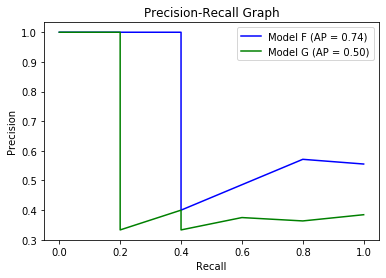

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

class_F = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1])
proba_F = np.array([0.05, 0.05, 0.15, 0.15, 0.25, 0.25, 0.35, 0.35, 0.45, 0.45, 0.55, 0.55, 0.65, 0.85, 0.95])

class_G = np.array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
proba_G = np.array([0.05, 0.05, 0.15, 0.15, 0.25, 0.25, 0.25, 0.35, 0.35, 0.45, 0.55, 0.55, 0.65, 0.75, 0.95])

precision_F, recall_F, _ = precision_recall_curve(class_F, proba_F)
precision_G, recall_G, _ = precision_recall_curve(class_G, proba_G)

ap_F = average_precision_score(class_F, proba_F)
ap_G = average_precision_score(class_G, proba_G)

plt.title('Precision-Recall Graph')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot(recall_F, precision_F, 'b', label = 'Model F (AP = %0.2F)'%ap_F)   
plt.plot(recall_G, precision_G, 'g', label = 'Model G (AP = %0.2F)'%ap_G)  

plt.legend(loc='upper right')
plt.show()